50 kmh sign recognition
=======================

For a given set of images, where the location of traffic signs was already found, we will determine if a 50 km/h limit sign is shown.

# Import Libraries

In [2]:
%%capture
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import torch
from torch.nn import Linear, ReLU, MSELoss, Conv2d, Module, BatchNorm2d, Dropout, Flatten, Sigmoid, MaxPool2d
from torch.optim import Adam, SGD

import os

import cv2
from PIL import Image
from PIL.PpmImagePlugin import PpmImageFile


from io import StringIO
import pickle
from zipfile import ZipFile

c:\Users\cypri\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Data

## Get images from the German Traffic Sign Recognition Dataset

In [4]:
%%capture
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

In [5]:
with ZipFile('GTSRB_Final_Training_Images.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [6]:
data_folder = '.'
if os.path.isdir(os.path.join(data_folder,'GTSRB')): # check if the folder GTSRB is here
    print('Data folder found')
else:
    print('Data folder not found. Check paths')


Data folder found


## Fill a dataframe with all our images from the GTSRB

In [32]:
def extract_data(train_img_paths):
    all_df = {'filename':[],'physical_sign_no':[],'view_no':[],'label':[]}
    for root, dirs, _ in os.walk(train_img_paths):
        for _dir in sorted(dirs):
            files = os.listdir(os.path.join(root,_dir))
            for file in sorted(files):
                if 'ppm' in file:
                    all_df['filename'].append(os.path.join(root,_dir,file))
                    all_df['physical_sign_no'].append(file.split('_')[0])
                    all_df['view_no'].append(file.split('_')[1].split('.')[0])
                    all_df['label'].append(_dir)
    all_df = pd.DataFrame(all_df)
    return all_df

In [33]:
train_img_paths = os.path.join(data_folder, 'GTSRB/Final_Training/Images')
all_df = extract_data(train_img_paths)

## Balance the dataset to make sure roughly the same amount of traffic signs are in train, validation and test dataset

In [31]:
def separate_data(all_df, test_fraction=0.2, validation_fraction=0.2):
    """When separating the dataset it must be achieved that:
    1. the val-train-test split number is roughly honored
    2. For all labels, which means for all types of traffic signs, at least one has to be in train, val and test
    3. Several views of exactly the same traffic sign (view_no) should be share among train, val and test
    """
    train_df = []
    val_df = []
    test_df = []

    for label_no in range(int(all_df['label'].max())+1):
        
        instances_tmp = []    
        label_no = '{:05}'.format(label_no) # all numbers are string and have 5 leading zeros
        
        max_phy_sign = int(all_df[all_df['label'].isin([label_no])]['physical_sign_no'].max())
        phy_signs = ['{:05}'.format(sign_no) for sign_no in range(max_phy_sign+1)]
        
        # Go over all sign ids for that label and make a list
        for sign_no in phy_signs:
            tmp = all_df[all_df['label'].isin([label_no]) & all_df['physical_sign_no'].isin([sign_no])]
            instances_tmp.append(tmp)
        
        train_by_label, test_by_label = train_test_split(instances_tmp, test_size=test_fraction)
        train_by_label, val_by_label = train_test_split(train_by_label, test_size=validation_fraction)
        
        train_df.extend(train_by_label)
        test_df.extend(test_by_label)
        val_df.extend(val_by_label)

    train_df = pd.concat(train_df)
    test_df = pd.concat(test_df)
    val_df = pd.concat(val_df)
    return train_df, test_df, val_df

In [34]:
train_df, test_df, val_df = separate_data(all_df)

# Data investigation

## Associate a to each label a traffic sign name 

In [37]:
class_names_csv = StringIO("""ClassId;SignName
0;Speed limit (20km/h)
1;Speed limit (30km/h)
2;Speed limit (50km/h)
3;Speed limit (60km/h)
4;Speed limit (70km/h)
5;Speed limit (80km/h)
6;End of speed limit (80km/h)
7;Speed limit (100km/h)
8;Speed limit (120km/h)
9;No passing
10;No passing for vechiles over 3.5 metric tons
11;Right-of-way at the next intersection
12;Priority road
13;Yield
14;Stop
15;No vechiles
16;Vechiles over 3.5 metric tons prohibited
17;No entry
18;General caution
19;Dangerous curve to the left
20;Dangerous curve to the right
21;Double curve
22;Bumpy road
23;Slippery road
24;Road narrows on the right
25;Road work
26;Traffic signals
27;Pedestrians
28;Children crossing
29;Bicycles crossing
30;Beware of ice/snow
31;Wild animals crossing
32;End of all speed and passing limits
33;Turn right ahead
34;Turn left ahead
35;Ahead only
36;Go straight or right
37;Go straight or left
38;Keep right
39;Keep left
40;Roundabout mandatory
41;End of no passing
42;End of no passing by vechiles over 3.5 metric tons
""")

classes = pd.read_csv(class_names_csv,sep=';')
class_names = {}
for i, row in classes.iterrows():
    class_names['{:05}'.format(row[0])] = row[1]

## Visualize the data

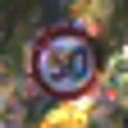

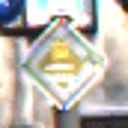

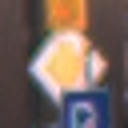

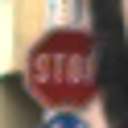

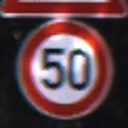

In [39]:
for i in random.choices(range(len(train_df)),k=5):
    im = Image.open(train_df.iloc[i]['filename'])
    im = im.resize(size=(128,128))
    display(im)

## Check distribution of classes

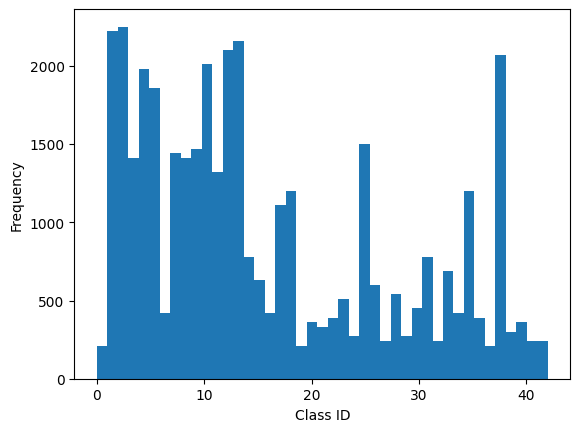

In [40]:
# Class ids
y = all_df['label'].astype(int).values

# Let's look at the data distribution
class_cardinality,_,_ = plt.hist(y,bins=y.max()+1)
_ = plt.xlabel('Class ID')
_ = plt.ylabel('Frequency')

## Check the most represented and most underrepresented sign

In [41]:
stats = [(class_cardinality[i],class_names['{:05}'.format(i)]) for i in range(len(class_names))]

stats = pd.DataFrame(stats,columns=['cardinality','name'])

class_ids_by_cardinality = stats['cardinality'].argsort().values

for i in range(0,4):
    name = class_names['{:05}'.format(class_ids_by_cardinality[i])]
    print (f'Tail class: {name}')
for i in range(1,5):
    name = class_names['{:05}'.format(class_ids_by_cardinality[-i])]
    print (f'Head class: {name}')

Tail class: Speed limit (20km/h)
Tail class: Go straight or left
Tail class: Dangerous curve to the left
Tail class: End of all speed and passing limits
Head class: Speed limit (50km/h)
Head class: Speed limit (30km/h)
Head class: Yield
Head class: Priority road


## Let's investigate the image sizes

In [44]:
def get_dimension(files):
    sizes=[]
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    for filename in files:
        img = cv2.imread(filename, flags)
        sizes.append(max(img.shape[0], img.shape[1]))
    return sizes

sizes = get_dimension(all_df['filename'])

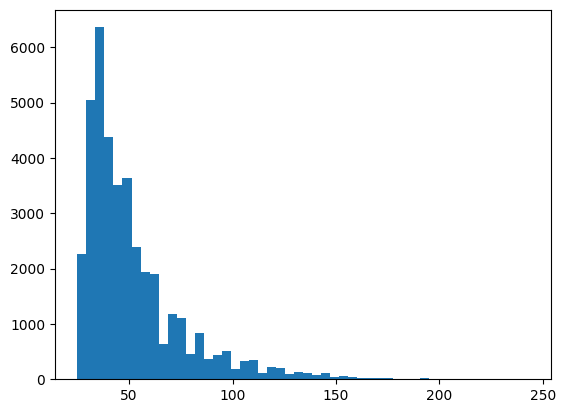

In [43]:
plt.hist(sizes, bins=50)
plt.show()

# Modelling

## Creating a Model

In [10]:
#Creating a CNN class
class ConvNeuralNet(Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding='same')
        self.maxpool1 = MaxPool2d(kernel_size=2)
        self.conv_layer2 = Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding='same')
        self.maxpool2 = MaxPool2d(kernel_size=2)

        self.relu = ReLU()
        self.flatten = Flatten()
        self.dropout = Dropout(0.3) # layer to prevent overfitting

        self.linear1 = Linear(16**2*3, 50)
        self.linear2 = Linear(50, 1)
        self.sigmoid = Sigmoid() # to obtain probabilities
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.maxpool1(out)
        out = self.conv_layer2(out)
        out = self.maxpool2(out)
        
        out = self.relu(out)
        out = self.flatten(out)
        out = self.dropout(out)
        
        out = self.linear1(out)
        out = self.linear2(out)
        out = self.sigmoid(out).squeeze() # to return a tensor of 1 dimension
        return out

## Structure, Save and Load Data

In [8]:
def minmax_normalization(orig_array):
    """
    Make a minmax normalization on the 3 channels of each images
    """
    # expects numpy array with order c, h, w
    if orig_array.shape[0] != 3:
        print('Warning: The first dimension is not 3. It seems that is not the channel dimension')
    _array = orig_array.copy()
    for i, channel in enumerate(_array):
        _array[i] = (_array[i] - _array[i].min())/(_array[i].max()-_array[i].min())
    return _array

In [7]:
class RoadSignDataset(torch.utils.data.Dataset):
    """
    Create a loader from a datasets allowing to ease process
    """
    def __init__(self, filenames, labels):
        'Initialization'
        assert len(filenames)==len(labels)
        self.filenames = filenames
        is_50kmh = labels == '{:05}'.format(2) # Introduce binary labels, 50kmh sign or not
        self.labels = np.array(is_50kmh, dtype=np.float32)

        images = []
        for filename in self.filenames:
            img = Image.open(filename)
            img = img.resize((64,64)) # standardize formats
            if isinstance(img,PpmImageFile) or isinstance(img,Image.Image):
                # Get the PIL image to the cv2 format to have the uniform channel colors
                img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            img = img.transpose(2,0,1) # channel in first
            img = np.array(minmax_normalization(img.astype(np.float32)))
            images.append(img)
        self.images = np.array(images)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

    def __getitem__(self, index):
        'Generates one sample of data'
        return self.images[index], self.labels[index]

class Loader(torch.utils.data.DataLoader):
    "Subclass DataLoader class to get easily labels and images tensors"
    def __init__(self, dataset, batch_size, shuffle):
        super().__init__(dataset, batch_size, shuffle)
        self.labels = torch.tensor(self.dataset.labels)
        self.images = torch.tensor(self.dataset.images)

In [4]:
dset_names = ["train_df","test_df", "val_df"]
loader_names = [name[:-2]+"loader" for name in dset_names]

In [63]:
batch_size = 32
dset = {}
loader = {}

for idx, df in enumerate([train_df, test_df, val_df]):
    dset[dset_names[idx]] = RoadSignDataset(df['filename'], df['label'])
    loader[loader_names[idx]] = Loader(dataset = dset[dset_names[idx]],
                                           batch_size = batch_size,
                                           shuffle = True)

Save the Dataloader

In [5]:
def save_loader(loader):
    for loader_name in loader_names:
        with open("src/"+loader_name,'wb') as file:
            pickle.dump(loader[loader_name], file)
def load_loader():
    loader = {}
    for loader_name in loader_names:
        with open('src/'+loader_name, 'rb') as file:
            loader[loader_name] = pickle.load(file)
    return loader

Execute the following Scripts to load train_loader, val_loader and test_loader

In [8]:
loader = load_loader()

## Training our model

In [36]:
num_epochs = 30
learning_rate = 0.001
criterion = MSELoss()
model = ConvNeuralNet()
optimizer = Adam(model.parameters(), lr= learning_rate)
total_step = len(loader["train_loader"])

In [29]:
def get_accuracy(y_true, y_prob):
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5
    return (y_true == y_prob).sum().item() / y_true.size(0)

In [30]:
def result_by_epoch(epoch, num_epochs, train_acc, train_loss, val_acc, val_loss):
        # print accuracy and loss for validation and training dset 
        print("""Epoch [{}/{}] train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}""".format(
            epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

def train(model, train_loader, val_loader, criterion, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hist_loss = pd.DataFrame()
    for epoch in range(num_epochs):
        #Load in the data in batches using the train_loader object
        accuracy = 0
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)  
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accuracy+=get_accuracy(labels, outputs)/total_step

        predicts = model(val_loader.images)
        val_loss = criterion(predicts, val_loader.labels)
        val_accuracy = get_accuracy(val_loader.labels, predicts)
        result_by_epoch(epoch, num_epochs, accuracy, loss.item(), val_accuracy, val_loss)
        hist_loss = pd.concat([hist_loss, pd.DataFrame([[loss.item(), val_loss.detach().numpy()]]) ])
    return hist_loss

In [37]:
hist_loss = train(model, loader["train_loader"], loader["val_loader"], criterion, num_epochs)

Epoch [1/30] train_loss: 0.0530, train_acc: 0.9400, val_loss: 0.0421, val_acc: 0.9498
Epoch [2/30] train_loss: 0.0011, train_acc: 0.9597, val_loss: 0.0273, val_acc: 0.9665
Epoch [3/30] train_loss: 0.0009, train_acc: 0.9684, val_loss: 0.0223, val_acc: 0.9716
Epoch [4/30] train_loss: 0.0405, train_acc: 0.9741, val_loss: 0.0233, val_acc: 0.9725
Epoch [5/30] train_loss: 0.0011, train_acc: 0.9762, val_loss: 0.0189, val_acc: 0.9761
Epoch [6/30] train_loss: 0.0468, train_acc: 0.9763, val_loss: 0.0183, val_acc: 0.9767
Epoch [7/30] train_loss: 0.0078, train_acc: 0.9792, val_loss: 0.0239, val_acc: 0.9683
Epoch [8/30] train_loss: 0.0197, train_acc: 0.9808, val_loss: 0.0202, val_acc: 0.9755
Epoch [9/30] train_loss: 0.0079, train_acc: 0.9800, val_loss: 0.0161, val_acc: 0.9819
Epoch [10/30] train_loss: 0.0009, train_acc: 0.9820, val_loss: 0.0192, val_acc: 0.9767
Epoch [11/30] train_loss: 0.0001, train_acc: 0.9810, val_loss: 0.0178, val_acc: 0.9786
Epoch [12/30] train_loss: 0.0000, train_acc: 0.9834,

## Visualization of the losses

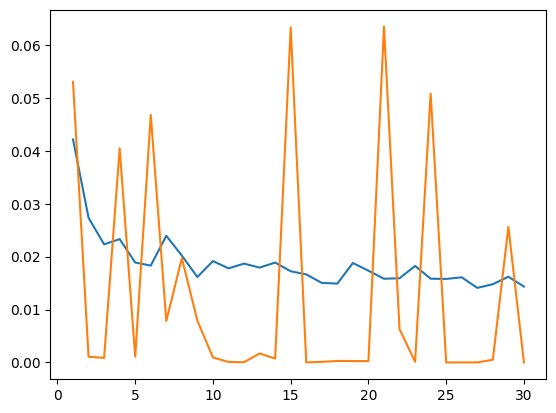

In [38]:
hist_loss.columns = ["triain_loss", "val_loss"]
plt.plot(range(1,num_epochs+1),hist_loss["val_loss"])
plt.plot(range(1,num_epochs+1), hist_loss["triain_loss"])
plt.show()

## Save and Load model

In [39]:
def save_model(model):
    with open('src/model.pkl', 'wb') as file:
        pickle.dump(model, file)

def load_model():
    with open('src/model.pkl', 'rb') as file:
        model = pickle.load(file)
    return model

In [41]:
model = load_model()

# Visualization

In [42]:
def show_stats(bin_labels, pred): 
    print('Precision: %.3f' % precision_score(bin_labels, pred))
    print('Accuracy: %.3f' % accuracy_score(bin_labels, pred))
    print('Recall: %.3f' % recall_score(bin_labels, pred))
    print('F1 Score: %.3f' % f1_score(bin_labels, pred))

    conf_matrix = confusion_matrix(y_true=bin_labels, y_pred=pred)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

torch.float32 int32
Precision: 0.725
Accuracy: 0.982
Recall: 0.922
F1 Score: 0.812


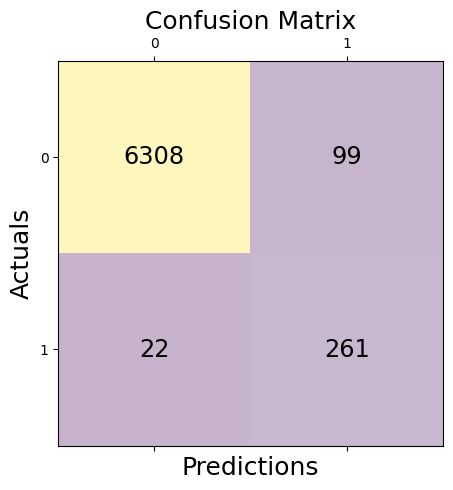

In [43]:
predicts = model(loader["val_loader"].images)
predicts = predicts.detach().numpy() # convert tensors to arrays
predicts = np.array(list(map(round, predicts))) # convert floats to ints
labels = loader["val_loader"].labels
print(labels.dtype, predicts.dtype)
show_stats(predicts, labels)